In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import torch
import numpy as np
import scipy as sp
import math
import copy
from matplotlib import pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm

from test_sampler import TestProblem, TestProblem2

In [20]:
def nesterov(x_0, grad, L, mu, K):
    x_cur = x_0
    y_cur = x_0
    x_list = [x_0]
    y_list = [x_0]
    for i in range(K):
        x_upd = y_cur - (1 / L) * (grad(y_cur, L))
        y_upd = x_upd + ((np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))) * (x_upd - x_cur)

        x_list.append(x_upd)
        y_list.append(y_upd)

        x_cur = x_upd
        y_cur = y_upd

    return x_list, y_list



In [21]:
# test_problem = TestProblem(gamma=1e5)
test_problem = TestProblem2()

100%|██████████| 5000/5000 [00:08<00:00, 600.18it/s]


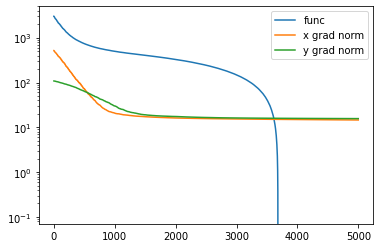

In [42]:
# ACRCD
history = []
grad_x_norms = []
grad_y_norms = []

# y (paper) = q(code_)

def ACRCD(x_0, y_0, K):
    x_list = [x_0]
    y_list = [y_0]

    z1_cur = x_0
    z2_cur = y_0

    q1_cur = x_0
    q2_cur = y_0

    L1 = L2 = 5000
    beta = 1 / 2

    n_ = L1 ** beta + L2 ** beta

    # q_cur_block (code) = y (paper)
    # z_cur_block (code) = z (paper)
    for i in tqdm(range(K)):

        #####  redefine alpha, tau
        alpha = (i + 2) / (2 * n_ ** 2)
        tau = 2 / (i + 2)

        x1_upd = tau * z1_cur + (1 - tau) * q1_cur
        x2_upd = tau * z2_cur + (1 - tau) * q2_cur

        # test_problem.x = torch.tensor(x_upd, requires_grad=True)
        # test_problem.y = torch.tensor(y_upd, requires_grad=True)
        result, grad_x, grad_y = test_problem.calc(x1_upd, x2_upd)
        history.append(result.item())
        grad_x_norms.append(np.linalg.norm(grad_x))
        grad_y_norms.append(np.linalg.norm(grad_y))
        #         print(result, torch.norm(grad_x), torch.norm(grad_y))

        index_p = np.random.choice([0, 1], p=[L1 ** beta / n_,
                                              L2 ** beta / n_])

        if index_p == 0:
            q1_upd = x1_upd - (1 / L1) * grad_x
            q2_upd = q2_cur

            z1_upd = z1_cur - (1 / L1) * alpha * n_ * grad_x
            z2_upd = z2_cur


        if index_p == 1:
            q1_upd = q1_cur
            q2_upd = x2_upd - (1 / L2) * grad_y

            z1_upd = z1_cur
            z2_upd = z2_cur - (1 / L2) * alpha * n_ * grad_y

        x_list.append(x1_upd)
        y_list.append(x2_upd)

        z1_cur = z1_upd
        z2_cur = z2_upd

        q1_cur = q1_upd
        q2_cur = q2_upd

    return x_list, y_list

x0 = np.random.random(1000)
y0 = np.random.random(1000)

x_list_ACRCD, y_list_ACRCD = ACRCD(x0, y0, 5000)

# plt.plot(torch.log(torch.tensor(history)))

plt.plot(torch.tensor(history), label='func')
plt.plot(torch.tensor(grad_x_norms), label='x grad norm')
plt.plot(torch.tensor(grad_y_norms), label='y grad norm')
plt.yscale("log")
plt.legend()
plt.show()

In [43]:
res_x, *gradients_x = test_problem.calc(x_list_ACRCD[-1], y_list_ACRCD[-1])
res_x

-349.0305285103366

In [53]:

history = []
grad_x_norms = []
grad_y_norms = []

# y (paper) = q(code_)
count_one, count_two = 0, 0

def ACRCD_star(x_0, y_0, K):
    global count_one, count_two
    ADAPRIVE_DELTA = 1

    x_list = [x_0]
    y_list = [y_0]

    z1_cur = x_0
    z2_cur = y_0

    q1_cur = x_0
    q2_cur = y_0

    L1 = L2 = 5000
    beta = 1 / 2


    # q_cur_block (code) = y (paper)
    # z_cur_block (code) = z (paper)
    for i in tqdm(range(K)):

        #####  redefine alpha, tau
        # n_ = L1 ** beta + L2 ** beta
        # alpha = (i + 2) / (2 * n_ ** 2)
        tau = 2 / (i + 2)

        x1 = tau * z1_cur + (1 - tau) * q1_cur
        x2 = tau * z2_cur + (1 - tau) * q2_cur

        result, grad_x, grad_y = test_problem.calc(x1, x2)
        history.append(result.item())
        grad_x_norms.append(np.linalg.norm(grad_x).item())
        grad_y_norms.append(np.linalg.norm(grad_y).item())

        n_ = L1 ** beta + L2 ** beta
        index_p = np.random.choice([0, 1], p=[L1 ** beta / n_,
                                              L2 ** beta / n_])
        Ls = [L1, L2]
        Ls[index_p] /= 2

        # ADAPTIVE

        inequal_is_true = False
        # while not inequal_is_true:
        for i in range(100):
            xs = [x1, x2]

            res_x, *gradients_x = test_problem.calc(x1, x2)
            res_q, *gradients_q = test_problem.calc(q1_cur, q2_cur)
            sampled_gradient_x = gradients_x[index_p]

            inequal_is_true = 1 / (2 * Ls[index_p]) * np.linalg.norm(sampled_gradient_x) ** 2 <= res_x - res_q + ADAPRIVE_DELTA
            if inequal_is_true: break

            if index_p == 0:
                count_one += 1
                q1_cur = xs[index_p] - 1 / Ls[index_p] * sampled_gradient_x
            else:
                count_two += 1
                q2_cur = xs[index_p] - 1 / Ls[index_p] * sampled_gradient_x
            Ls[index_p] *= 2

            L1, L2 = Ls
            n_ = L1 ** beta + L2 ** beta
            alpha = (i + 2) / (2 * n_ ** 2)

        L1, L2 = Ls

        L1, L2 = Ls
        n_ = L1 ** beta + L2 ** beta
        alpha = (i + 2) / (2 * n_ ** 2)

        if index_p == 0:
            z1_upd = z1_cur - (1 / L1) * alpha * n_ * grad_x
            z2_upd = z2_cur

        if index_p == 1:
            z1_upd = z1_cur
            z2_upd = z2_cur - (1 / L2) * alpha * n_ * grad_y

        x_list.append(x1)
        y_list.append(x2)

        z1_cur = z1_upd
        z2_cur = z2_upd

    return x_list, y_list, [L1, L2]


x_list_ACRCD, y_list_ACRCD, Ls = ACRCD_star(np.random.random(1000), np.random.random(1000), 5000)

# plt.plot(torch.log(torch.tensor(history)))

plt.plot(torch.tensor(history), label='func')
plt.plot(torch.tensor(grad_x_norms), label='x grad norm')
plt.plot(torch.tensor(grad_y_norms), label='y grad norm')
plt.yscale("log")
plt.legend()
plt.show()

  3%|▎         | 149/5000 [00:20<11:10,  7.23it/s] 


KeyboardInterrupt: 

In [54]:
res_x, *gradients_x = test_problem.calc(x_list_ACRCD[-1], y_list_ACRCD[-1])
res_x

-29580.729135665522

In [55]:
Ls

[78.125, 19.53125]

In [56]:
print(Ls)

[78.125, 19.53125]


In [36]:
# gamma=1e5 [1250.0, 10000.0]
# gamma=1e-5 [2500.0, 10000.0]


[-2.1316282072803006e-14,
 11.111111111111114,
 22.22222222222226,
 33.33333333333329,
 44.44444444444447,
 55.55555555555555,
 66.66666666666674,
 77.77777777777784,
 88.88888888888903,
 100.00000000000027]

In [137]:
test_problem = TestProblem2()

In [138]:
test_problem.calc(np.random.random((10)), np.random.random((10)))

(57.792657198596416,
 array([-28.02355486,  14.31500701,  46.41015183,  -7.31248952,
         41.0677855 ,   2.24061996,  21.42358445,   5.4881576 ,
        -20.09256052, -22.28616465]),
 array([-1.49450929, -2.16805852,  2.73684743,  3.39673907,  2.36557687,
         2.53900157,  1.52628924,  7.28348362,  0.08490437, -4.52211896]))

In [102]:
x = np.random.random((10))
1/ 2 * A @ np.transpose(x) @ x

39.94982657966037

In [93]:
x

array([0.80042496, 0.1027337 , 0.52891668, 0.68247215, 0.1476809 ,
       0.22858593, 0.0727249 , 0.26590332, 0.68281322, 0.937347  ])